<a href="https://colab.research.google.com/github/Supersamk13/Machine-Learning-and-Data-Science/blob/main/Data_Science_and_Machine_Learning_Project_Interstate_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Hello, my name is Samuel Kinstlinger. Over the past couple years I have been working on growing my skillset is the fields of data science and machine learing. This is a project I completed early on in my endeavor to practice data cleaning, data preprocessing, data visualization, and implementing regression models. I will be using a data set from Kaggle that gives information on the weather, date and time, and traffic volume.

### Goals
* Answer important questions about interstate traffic and the underlying related factors
* Implement and tune machine learning models to best predict interstate traffic volume

### Outline
* Getting to Know the Data
* EDA
* Data Visualization
* Data Cleaning and Preprocessing
* Machine Learning
* Conclusion

In [321]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [322]:
# Set up data frame
url='https://github.com/Supersamk13/Machine-Learning-and-Data-Science/raw/main/Metro_Interstate_Traffic_Volume%5B1%5D.csv'
traffic_df=pd.read_csv(url)

# Getting to Know the Data
* Understanding feature data types and information

In [323]:
# Getting to Know the Data
print(traffic_df.head())
print(traffic_df.tail())

  holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0    None  288.28      0.0      0.0          40       Clouds   
1    None  289.36      0.0      0.0          75       Clouds   
2    None  289.58      0.0      0.0          90       Clouds   
3    None  290.13      0.0      0.0          90       Clouds   
4    None  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918  
      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0   

In [324]:
print(traffic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None


All data is non-null; no need to fill or remove missing values

In [325]:
for index in range(traffic_df.shape[1]):
  print(traffic_df.columns[index])
  print(traffic_df.iloc[:,index].unique())

holiday
['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
temp
[288.28 289.36 289.58 ... 306.08 304.41 304.9 ]
rain_1h
[0.0000e+00 2.5000e-01 5.7000e-01 3.8000e-01 3.0000e-01 2.9000e-01
 4.4000e-01 3.6000e-01 2.1600e+00 3.3900e+00 8.4000e-01 7.6000e-01
 5.1000e-01 6.9000e-01 1.0000e+00 1.2900e+00 1.3400e+00 1.8400e+00
 1.7000e+00 4.7000e-01 1.4100e+00 1.4400e+00 7.0000e-01 3.1800e+00
 6.1000e-01 6.4000e-01 1.0200e+00 5.4200e+00 8.6400e+00 5.7400e+00
 4.9800e+00 3.6500e+00 6.8000e-01 4.6000e-01 4.2000e-01 1.5200e+00
 8.9000e-01 1.4000e+00 1.2190e+01 2.2900e+00 7.5400e+00 6.9400e+00
 1.6380e+01 1.7800e+00 2.5400e+00 9.1400e+00 3.0500e+00 1.6500e+00
 4.4450e+01 3.8100e+00 5.8400e+00 3.5600e+00 7.3700e+00 1.3500e+00
 1.6000e+01 1.0540e+01 1.2700e+00 5.0800e+00 1.9900e+01 2.5320e+01
 2.1420e+01 5.5900e+00 7.1100e+00 5.9700e+00 9.5300e+00 2.0

In [326]:
# Stats about each numeric feature
print(traffic_df.describe())

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


In [327]:
# Stats about each categorical feature
print(traffic_df.describe(include='object'))

       holiday weather_main weather_description            date_time
count    48204        48204               48204                48204
unique      12           11                  38                40575
top       None       Clouds        sky is clear  2013-05-19 10:00:00
freq     48143        15164               11665                    6


* holiday is very imbalanced towards no holiday
* holiday and weather_main have a small amount of categories making One-Hot Encoding a viable option for some models (maybe also weather_description)
* For date_time, second is most likely unimportant; note to compare model performance including second vs. excluding second
* Above comment may also be applicable for minute
* date_time may be tricky for parametric models as it requires nuance for analysis


### Feature Conclusions
* holiday- Categorical, US National holidays plus regional holidays
* temp- Numeric, Average temp in kelvin
* rain_1h- Numeric, Amount in mm of rain that occurred in the hour
* snow_1h- Numeric, Amount in mm of snow that occurred in the hour
* clouds_all- Numeric, Percentage of cloud cover
* weather_main- Categorical, Short textual description of the current weather
* weather_description- Categorical, Longer textual description of the current weather
* date_time- DateTime, Hour of the data collected in local CST time
* traffic_volume- Numeric Hourly I-94 ATR 301 reported westbound traffic volume



### Other Data Info
* Shape = (48204, 9)
* Traffic is westbound
* Traffic is between Saint Paul and Minneapolis
* Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Collected from 2012-2018.

# EDA
* What are the best weather indicators of heavy traffic?
* During which time of day is traffic the heaviest (hours and day vs. night)?
* During which time of the year if traffic the heaviest (months and winter vs. summer)?

# Data Visualization

* Visualize numeric data
* Eliminate skew in features and target (balance dataset)
* Ensure normality and unimodality in numerical features

### traffic_volume

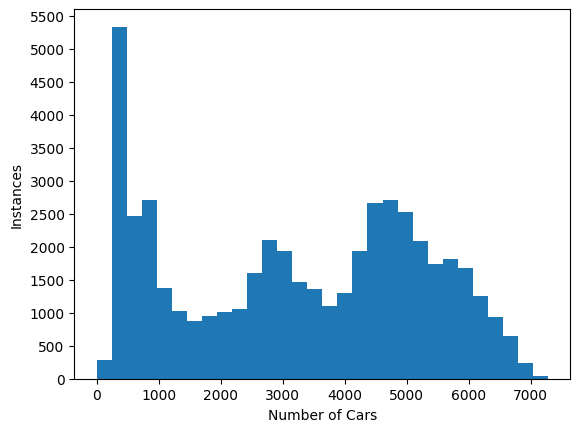

<Figure size 1000x600 with 0 Axes>

In [328]:
# Traffic volume distribution
plt.hist(traffic_df['traffic_volume'], bins=30)

# Labels
plt.xlabel('Number of Cars')
plt.ylabel('Instances')

# Arange ticks
plt.yticks(np.arange(0,6000,500))
plt.xticks(np.arange(0,8000,1000))

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

### clouds_all

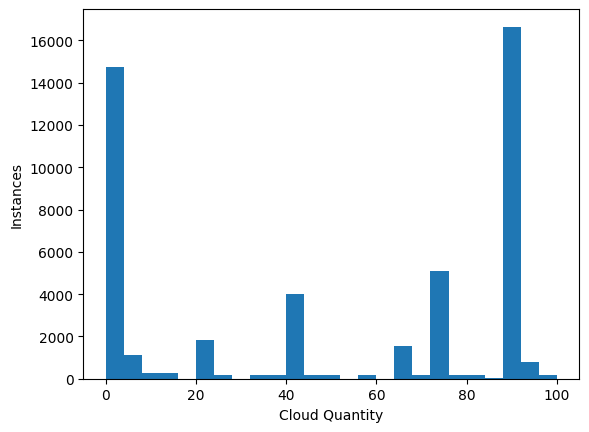

<Figure size 1000x600 with 0 Axes>

In [329]:
# Rain volume distribution
plt.hist(traffic_df['clouds_all'], bins=25)

# Labels
plt.xlabel('Cloud Quantity')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

### temp

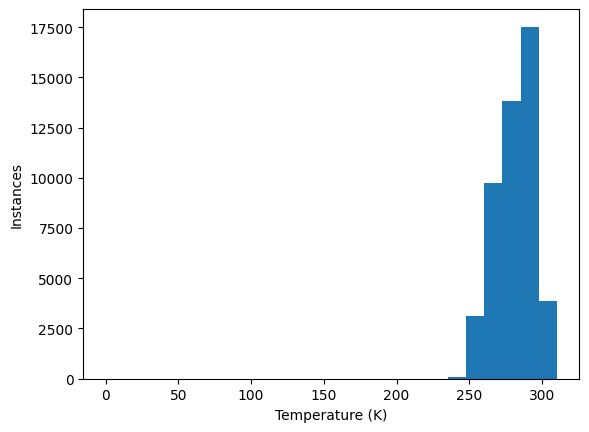

<Figure size 1000x600 with 0 Axes>

In [330]:
# Rain volume distribution
plt.hist(traffic_df['temp'], bins=25)

# Labels
plt.xlabel('Temperature (K)')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

* Temp appears normal but has some skew due to very low values
* Outlier removal is permitted here

In [331]:
# Removing rain_1h outliers
traffic_df=traffic_df[(np.abs(stats.zscore(traffic_df['temp'])) < 3)]

# Reset index
traffic_df=traffic_df.reset_index()

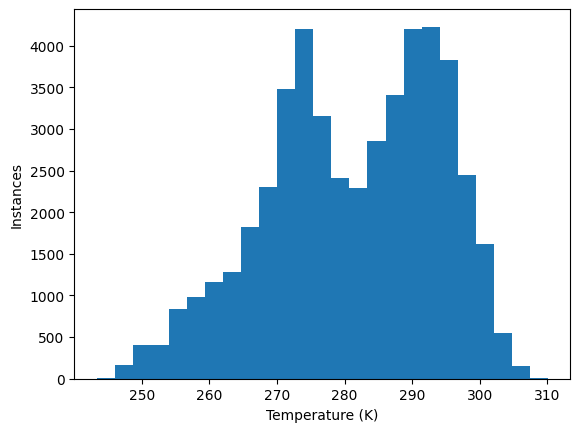

<Figure size 1000x600 with 0 Axes>

In [332]:
# Rain volume distribution
plt.hist(traffic_df['temp'], bins=25)

# Labels
plt.xlabel('Temperature (K)')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

### rain_1h

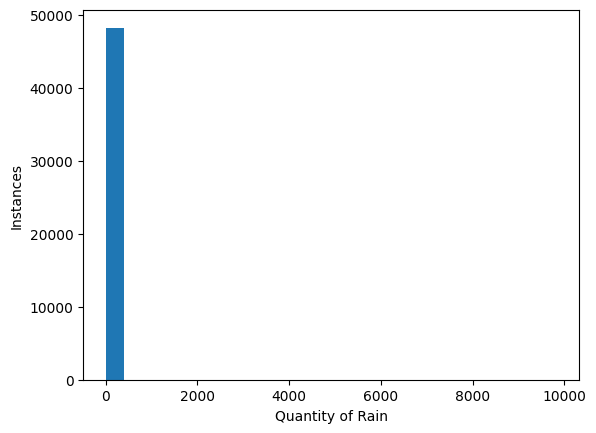

<Figure size 1000x600 with 0 Axes>

In [333]:
# Rain volume distribution
plt.hist(traffic_df['rain_1h'], bins=25)

# Labels
plt.xlabel('Quantity of Rain')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

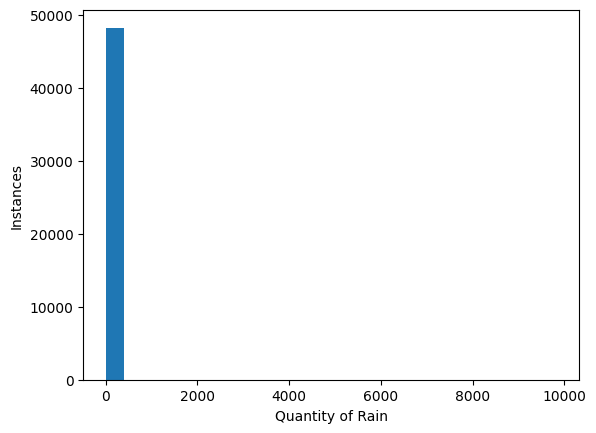

<Figure size 1000x600 with 0 Axes>

In [334]:
# Rain volume distribution
plt.hist(traffic_df['rain_1h'], bins=25)

# Labels
plt.xlabel('Quantity of Rain')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

* Outliers appear to be heavily skewing the rain data
* Due to there being a small amount of outliers and large amount of data, removing the outliers is a viable choise

In [335]:
# Removing rain_1h outliers
traffic_df=traffic_df[(np.abs(stats.zscore(traffic_df['rain_1h'])) < 1)]

# Reset index
traffic_df=traffic_df.reset_index()

In [336]:
# Getting statistical data about rain_1h
print(traffic_df['rain_1h'].describe())

count    48192.000000
mean         0.129190
std          0.971121
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         44.450000
Name: rain_1h, dtype: float64


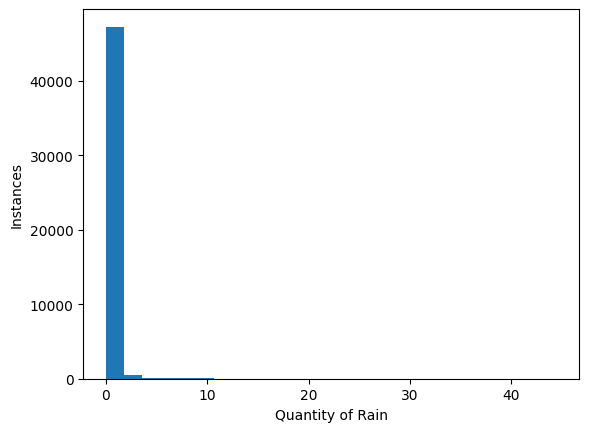

<Figure size 1000x600 with 0 Axes>

In [337]:
# Rain volume distribution
plt.hist(traffic_df['rain_1h'], bins=25)

# Labels
plt.xlabel('Quantity of Rain')
plt.ylabel('Instances')

# Manipulate figure size
plt.figure(figsize=(10,6))

# Show plot
plt.show()

* rain_1h is still heavily right skewed, but taking away more data may degrade the model's ability to make predictions in high rain_1h cases

In [338]:
# Testing skew rain_1h
print(traffic_df.skew(axis=0, numeric_only='True'))

level_0           -0.000037
index             -0.000442
temp              -0.364178
rain_1h           16.098725
snow_1h           48.361457
clouds_all        -0.197639
traffic_volume    -0.089640
dtype: float64


* rain_1h, snow_1h are both heavily skewed features
* temp is a moderately skewed feature
* I will attempt to rectify all of them
* the skew for temp is fundementally different that for rain_1h and snow_1h
* rain_1h and snow_1h are both nonnegative, continuous variables that are right skewed and are highly concentrated/clumped at 0

In [339]:
traffic_df['rain_1h']=traffic_df['rain_1h'].apply(lambda x: x+.1)
traffic_df['rain_1h'] = stats.boxcox(traffic_df['rain_1h'])[0]

### snow_1h